<a href="https://colab.research.google.com/github/zeynepiremkesler/Designing-AI-for-Plant-Image-Detection-and-User-Interface/blob/main/ResNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
!pip install tqdm

In [148]:
import cv2
import os
import random
import numpy as np
import time
import uuid
import json
from matplotlib import pyplot as plt
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.callbacks import TensorBoard

In [149]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


In [150]:
from google.colab import drive

In [151]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/dataset/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)


In [153]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/dataset/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)

In [154]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/dataset/valid/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

In [155]:
def load_labels(label_path):
    label_content = tf.io.read_file(label_path)
    label_content = tf.strings.split(label_content, sep=' ')
    class_label = tf.strings.to_number(label_content[0], tf.int32)
    bbox = tf.strings.to_number(label_content[1:], tf.float32)
    return class_label, bbox

In [156]:

def load_labels(label_path):
    raw_content = tf.io.read_file(label_path)
    # Split the content by newlines and then by spaces
    split_content = tf.strings.split(raw_content, '\n')
    # You might need to adjust the indices if there are multiple lines
    label_line = split_content[0]  # Assuming the first line is the one we want
    label_content = tf.strings.split(label_line, ' ')
    class_label = tf.strings.to_number(label_content[0], out_type=tf.int32)
    bbox = tf.strings.to_number(label_content[1:], out_type=tf.float32)
    return class_label, bbox

In [157]:
def prepare_dataset(image_paths, label_paths, batch_size=8):
    images = tf.data.Dataset.list_files(image_paths, shuffle=False)
    images = images.map(load_image)
    images = images.map(lambda x: tf.image.resize(x, (120, 120)))
    images = images.map(lambda x: x / 255)

    labels = tf.data.Dataset.list_files(label_paths, shuffle=False)
    labels = labels.map(lambda x: tf.py_function(load_labels, [x], [tf.int32, tf.float32]))

    dataset = tf.data.Dataset.zip((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [158]:
train_image_paths = '/content/drive/MyDrive/dataset/train/images/*.jpg'
train_label_paths = '/content/drive/MyDrive/dataset/train/labels/*.txt'
test_image_paths = '/content/drive/MyDrive/dataset/test/images/*.jpg'
test_label_paths = '/content/drive/MyDrive/dataset/test/labels/*.txt'
val_image_paths = '/content/drive/MyDrive/dataset/valid/images/*.jpg'
val_label_paths = '/content/drive/MyDrive/dataset/valid/labels/*.txt'

In [159]:
train_dataset = prepare_dataset(train_image_paths, train_label_paths, batch_size=8)
test_dataset = prepare_dataset(test_image_paths, test_label_paths, batch_size=8)
val_dataset = prepare_dataset(val_image_paths, val_label_paths, batch_size=8)


In [160]:
data_samples = train_dataset.as_numpy_iterator()
res = data_samples.next()

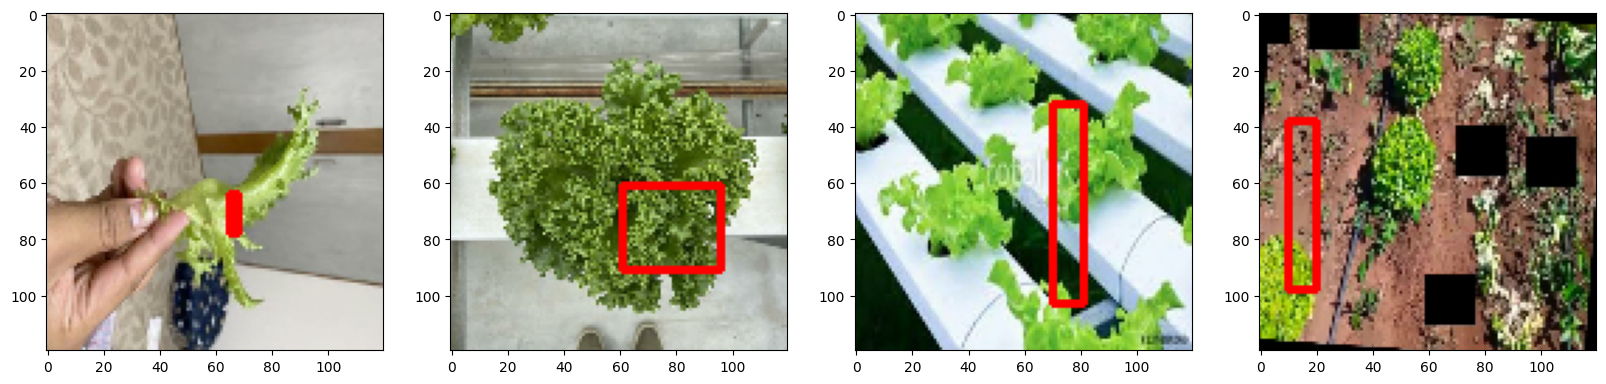

In [161]:
fig , ax = plt.subplots(ncols=4,figsize=(20,20))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    ax[idx].imshow(sample_image)

In [162]:
resnet = ResNet50(include_top=False)

In [163]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    resnet = ResNet50(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(resnet)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(resnet)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    model = Model(inputs=input_layer, outputs=[class2, regress2])
    return model

In [164]:
agri_model = build_model()

In [165]:
X, y = train_dataset.as_numpy_iterator().next()

In [166]:
X.shape

(8, 120, 120, 3)

In [167]:
classes, coords = agri_model.predict(X)

1/1 [==============================] - 2s 2s/step


In [168]:
classes, coords


(array([[0.5615377 ],
        [0.58791083],
        [0.6197126 ],
        [0.6404293 ],
        [0.57439446],
        [0.49667346],
        [0.6451806 ],
        [0.6229956 ]], dtype=float32),
 array([[0.3444814 , 0.806055  , 0.5310842 , 0.7595245 ],
        [0.34908655, 0.7791732 , 0.48232555, 0.7464678 ],
        [0.32807487, 0.789884  , 0.44980955, 0.7157263 ],
        [0.31326476, 0.77816296, 0.4635917 , 0.71093154],
        [0.34142202, 0.8053674 , 0.47091535, 0.737539  ],
        [0.39131954, 0.74567914, 0.5485262 , 0.7551231 ],
        [0.28919387, 0.8026114 , 0.4738219 , 0.74725974],
        [0.31554174, 0.7850522 , 0.4681594 , 0.7479379 ]], dtype=float32))

In [169]:
train = tqdm(range(100))

  0%|          | 0/100 [1:23:13<?, ?it/s]


In [170]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [171]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [172]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [173]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [174]:
localization_loss(y[1],coords).numpy()

4.7129245

In [175]:
classloss(y[0],classes).numpy()

0.90663385

In [176]:
class AgriModel(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [177]:
agri_model1 = AgriModel(agri_model)

In [178]:
agri_model1.compile(opt,classloss,regressloss)

In [179]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [180]:
hist = agri_model1.fit(train_dataset, epochs=10 ,validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/10
83/83 [==============================] - 253s 3s/step - total_loss: 6.3097 - class_loss: 0.0185 - regress_loss: 6.3004 - val_total_loss: 6.7127 - val_class_loss: 0.0000e+00 - val_regress_loss: 6.7127
Epoch 2/10
83/83 [==============================] - 244s 3s/step - total_loss: 5.9643 - class_loss: 8.4263e-09 - regress_loss: 5.9643 - val_total_loss: 3.3976 - val_class_loss: 0.0000e+00 - val_regress_loss: 3.3976
Epoch 3/10
83/83 [==============================] - 238s 3s/step - total_loss: 5.9229 - class_loss: 1.5167e-08 - regress_loss: 5.9229 - val_total_loss: 2.4637 - val_class_loss: 0.0000e+00 - val_regress_loss: 2.4637
Epoch 4/10
83/83 [==============================] - 237s 3s/step - total_loss: 5.8601 - class_loss: 0.0000e+00 - regress_loss: 5.8601 - val_total_loss: 2.8614 - val_class_loss: 0.0000e+00 - val_regress_loss: 2.8614
Epoch 5/10
83/83 [==============================] - 242s 3s/step - total_loss: 5.7982 - class_loss: 8.8697e-11 - regress_loss: 5.7982 - val_tota

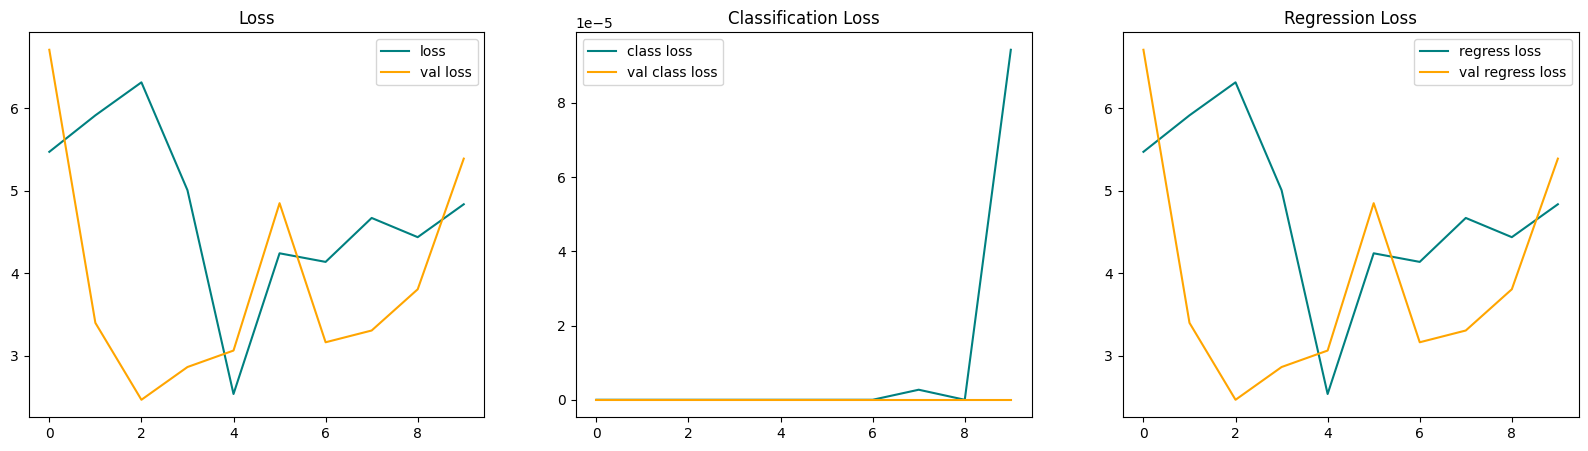

In [181]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [1]:
agri_model1.save('facetracker', save_format='tf')

NameError: name 'agri_model1' is not defined

In [6]:
!pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [7]:
from fastapi import Request


In [8]:
from fastapi import FastAPI, File, UploadFile, HTTPException, Request
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
from starlette.middleware.cors import CORSMiddleware
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import io

app = FastAPI()

In [3]:
@app.get("/", response_class=HTMLResponse)
async def read_item(request: Request):

    sample_image_path = "/content/drive/MyDrive/dataset1/test/img_8.jpg"
    predicted_class = predict_image(sample_image_path)

NameError: name 'FastAPI' is not defined

In [9]:
def index(request):
    # ...
    predicted_class = ...
    # ...

    return templates.TemplateResponse("index.html", {"request": request, "predicted_class": predicted_class})

In [10]:

@app.get("/", response_class=HTMLResponse)
async def read_item(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})


In [11]:
@app.post("/predict")
async def create_upload_file(file: UploadFile = File(...)):
    contents = await file.read()
    img = Image.open(io.BytesIO(contents))
    img_array = np.array(img.resize((224, 224))) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Batch boyutunu ekleyin
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    return {"class": predicted_class, "probabilities": predictions[0].tolist()}

ERROR:fastapi:Form data requires "python-multipart" to be installed. 
You can install "python-multipart" with: 

pip install python-multipart



RuntimeError: Form data requires "python-multipart" to be installed. 
You can install "python-multipart" with: 

pip install python-multipart


In [12]:
!uvicorn detection.ipynb:app --reload

/bin/bash: line 1: uvicorn: command not found
